# Bayesian Inference with Python
## PyData Munich, 2 Oct 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Black Forest

Below are some examples of how we can use PyMC3 (and Bayesian inference) to infer different parameters of our population statistical model.

### Data

In [2]:
def gen_tree_height(sample_size, samples, height_mean, height_variance):
    return np.random.normal(loc=height_mean, scale=height_variance, size=(samples, sample_size))

In [3]:
sample_size = 100
samples = 1
height_mean = 50 
height_variance = 20 

trees_height = gen_tree_height(sample_size, samples, height_mean, height_variance)

## Known variance, unknown mean

**Steps**:
- We already acquired some data: `trees_height`
- Define the model in python (all the inference components are defined withing this model)
- We choose a statistical model for our population: In our case we chose a normal distribution which has two variables
    - mean - unknown
    - variance - Known = 20
- Pick a prior distribution for the mean, depending on what we know about them
- Define a likelihood function, which is basically the the model of our population (normal distribution)
- Hit the inference button

![example1](example1.png)

In [4]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=30, sd=20)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=20, observed=trees_height)               

In [5]:
with black_forest_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)                

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mean]
The number of effective samples is smaller than 25% for some parameters.


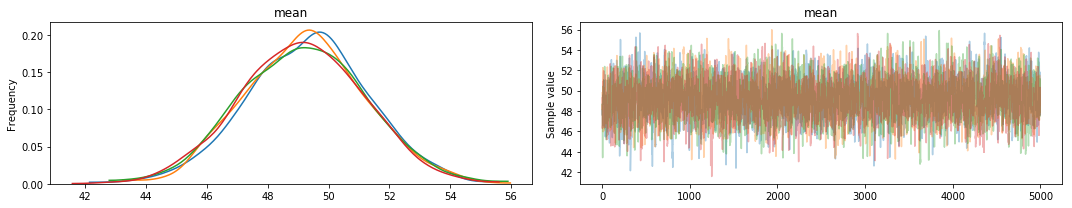

In [6]:
pm.traceplot(trace, figsize=(15, 3));

<br>
Summary statistics of the posterior distribution

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,49.220451,2.016477,0.036536,45.34602,53.202331,3493.864102,1.000907


In [8]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

True mean:  50
Estimated mean:  49.2204508285339


---

### On the imprtance of Prior

![prior_importance](imprtance_of_prior_mean.png)

In [9]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=10, sd=1)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=20, observed=trees_height)

In [ ]:
with black_forest_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mean]


In [ ]:
pm.traceplot(trace, figsize=(15, 3));

In [ ]:
pm.summary(trace)

In [ ]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

---

## Unknown variance, unknown mean

![example2](example2.png)

In [ ]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=30, sd=20)
    variance = pm.HalfNormal('variance', sd=10)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=variance, observed=trees_height)

In [ ]:
with black_forest_model:
    
    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

In [ ]:
pm.traceplot(trace, figsize=(15, 4));

In [ ]:
pm.summary(trace)

In [ ]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

print "True variance: ", height_variance
print "Estimated variance:", trace['variance'].mean()

### On the importance of prior

![chi2](chi2.png)

In [ ]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=30, sd=20)
    variance = pm.ChiSquared('variance', nu=6)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=variance, observed=trees_height)

In [ ]:
with black_forest_model:
    
    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

In [ ]:
pm.traceplot(trace, figsize=(15, 4));

In [ ]:
pm.summary(trace)

In [ ]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

print "True variance: ", height_variance
print "Estimated variance:", trace['variance'].mean()

### On the importance of the sample size

In [ ]:
sample_size = 100000
samples = 1
height_mean = 50 
height_variance = 20 

trees_height = gen_tree_height(sample_size, samples, height_mean, height_variance)

In [ ]:
with pm.Model() as black_forest_model:
    
    # Define prior
    mean = pm.Normal('mean', mu=50, sd=20)
    variance = pm.HalfNormal('variance', sd=2)
    
    # Defin likelihood function
    likelihood = pm.Normal('likelihood', mu=mean, sd=variance, observed=trees_height)

In [ ]:
with black_forest_model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step)

In [ ]:
pm.traceplot(trace, figsize=(15, 4));

In [ ]:
pm.summary(trace)

In [ ]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

print "True variance: ", height_variance
print "Estimated variance:", trace['variance'].mean()

---

## Resources

- [Short talk by Eric J. Ma](https://www.youtube.com/watch?v=p1IB4zWq9C8&t=1542s)
- [Tutorial by Christopher Fonnesbeck](https://www.youtube.com/watch?v=TMmSESkhRtI&t=139s)
- [Collection of examples]()